<a href="https://colab.research.google.com/github/abhilash1910/AI-Geometric-Learning/blob/master/Principal_Geodesic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Principal Geodesic Analysis

PGA is an extension of PCA for Riemann manifolds. For a set of points ${p_{1},...,p_{n}}$ on a Riemannian manifold, we have to describe the variation of a point pi in such a way that it becomes analogous to PCA. This implies projecting the components in a lower dimensional Euclidean subspace. For PCA in Riemannian domain, we have  the following properties:
 
- Karcher centered mean (mean-zero points) 
- Maximizing the variance (Frechet variance)
- Geodesic Submanifold (Unique vectors)

### Frechet Variance

Identifying the intrinsic variance is the first stage of  PGA . For the Riemannian manifold, we consider the Frechet variance as :

$$σ^{2}= 1/N 𝚺_{i=1}^{N} d(μ,x_{i})^2 = 1/N 𝚺_{i=1}^{N} ||log_{μ}(x_{i})^2||$$

where $\mu$ is the intrinsic mean of $x_{i}$ points on the manifold

### Geodesic Submanifold

The next step involves generalizing the PCA to Riemannian spaces by generalizing the notion of linear subspaces. A submanifold $H$ of $M$ is said to be a geodesic at $x\in H$  if all geodesics of $H$ passing through $x$ are also geodesics of $M$

### Projection Using Intrinstic Mean

Projection of a point $x$ on the geodesic submanifold is denoted as :
$$\pi_{H}(x)=arg min_{y \in H} d(x,y)^2=arg min_{y \in H} ||log_{x}(y)||^2 $$

Since projection is defined by a minimization, there is no guarantee that the projection of a point exists or that it is unique.
However, by restricting to a small enough neighborhood about
the mean, we can be assured that projection is unique for any
submanifold geodesic at the mean.
Now since we are realizing this as a Euclidean submanifold, we can apply linearization (subtraction log mapping) . Hence the projection operator can be optimized as 

$$\pi_{H}(x)=arg min_{y \in H} ||log_{p}(x) - log_{p}(y)||^2 $$

Since $log_{p}(y)$ is a vector , the projection operator can be written as

$$log_{p}(\pi_{H}(x))=arg min_{v \in T} ||log_{p}(x) - v||^2 $$

So if the set ${v_{1},......,v_{n}}$ forms an orthonormal basis in $T$ the projection operator can be further simplified as 

$$log_{p}(\pi_{H}(x))\approx 𝚺_{i=1}^{N}<v_{i},log_{p}(x)>$$






In [ ]:
!pip install geomstats

## Steps for PGA

Let $T_{\mu}M$ denote the tangent space of $M$ at the intrinsicmean $\mu$ of the $x_{i}$. Let $U \in T_{\mu}M$ be a neighborhood of 0 such
that projection is well-defined for all geodesic submanifolds
of $Exp_{\mu}(U)$. We assume that the data is localized enough
to lie within such a neighborhood. The principal geodesic
submanifolds are defined by first constructing an orthonormal
basis of tangent vectors $v_{1}, . . . , v_{d} \in T_{\mu}M$ that span the
tangent space $T_{\mu}M$. These vectors are then used to form a
sequence of nested subspaces $V_{k} = span({v_{1}, . . . , v_{k}}) ∩ U$. The principal geodesic submanifolds are the images of the $V_{k}$ under the exponential map: $H_{k} = Exp_{µ}(Vk)$. The
first principal direction is chosen to maximize the projected
variance along the corresponding geodesic:


$$v_{1}=argmax_{||v||=1} 𝚺_{i=1}^{N} ||log_{\mu}(\pi_{H}(x_{i}))||^2$$

$$H=Exp_{\mu}(span(({v}))∩ U)$$

Upon approximating with linearization principle , we get

$$v_{i}\approx 𝚺_{i=1}^{N}<v_{i},log_{p}(x)>$$


### Steps

- Calculating the Intrinsic Mean
- Calculating the tangent space at the mean and mapping every data point to the tangent space by Log map.
- Applying projection operator on the mapped values.

In this case, we are using the PGA implementation for SO3 group(rotational group) from the [geomstats library](https://github.com/geomstats/geomstats/blob/master/examples/tangent_pca_so3.py). 


In [4]:

"""Code abstracted from Geomstats library for PGA on SO3. The intrinsic mean uses the Frechet mean."""


"""Principal Component Analysis on Manifolds."""

import numbers
from math import log

from scipy.special import gammaln
from sklearn.decomposition._base import _BasePCA
from sklearn.utils.extmath import stable_cumsum, svd_flip

import geomstats.backend as gs
from geomstats.geometry.matrices import Matrices
from geomstats.geometry.symmetric_matrices import SymmetricMatrices
from geomstats.learning.frechet_mean import FrechetMean


def _assess_dimension_(spectrum, rank, n_samples, n_features):
    """Compute the likelihood of a rank ``rank`` dataset.
    The dataset is assumed to be embedded in gaussian noise of shape(n,
    dimf) having spectrum ``spectrum``.
    Parameters
    ----------
    spectrum : array of shape (n)
        Data spectrum.
    rank : int
        Tested rank value.
    n_samples : int
        Number of samples.
    n_features : int
        Number of features.
    Returns
    -------
    ll : float
        Log-likelihood.
    Notes
    -----
    This implements the method of `Thomas P. Minka:
    Automatic Choice of Dimensionality for PCA. NIPS 2000: 598-604`
    """
    if rank > len(spectrum):
        raise ValueError("The tested rank cannot exceed the rank of the" " dataset")

    pu = -rank * log(2.0)
    for i in range(rank):
        pu += gammaln((n_features - i) / 2.0) - log(gs.pi) * (n_features - i) / 2.0

    pl = gs.sum(gs.log(spectrum[:rank]))
    pl = -pl * n_samples / 2.0

    if rank == n_features:
        pv = 0
        v = 1
    else:
        v = gs.sum(spectrum[rank:]) / (n_features - rank)
        pv = -gs.log(v) * n_samples * (n_features - rank) / 2.0

    m = n_features * rank - rank * (rank + 1.0) / 2.0
    pp = log(2.0 * gs.pi) * (m + rank + 1.0) / 2.0

    pa = 0.0
    spectrum_ = spectrum.copy()
    spectrum_[rank:n_features] = v
    for i in range(rank):
        for j in range(i + 1, len(spectrum)):
            pa += log(
                (spectrum[i] - spectrum[j]) * (1.0 / spectrum_[j] - 1.0 / spectrum_[i])
            ) + log(n_samples)

    ll = pu + pl + pv + pp - pa / 2.0 - rank * log(n_samples) / 2.0

    return ll


def _infer_dimension_(spectrum, n_samples, n_features):
    """Infer the dimension of a dataset of shape (n_samples, n_features).
    The dataset is described by its spectrum `spectrum`.
    """
    n_spectrum = len(spectrum)
    ll = gs.empty(n_spectrum)
    for rank in range(n_spectrum):
        ll[rank] = _assess_dimension_(spectrum, rank, n_samples, n_features)
    return ll.argmax()


class TangentPCA(_BasePCA):
    r"""Tangent Principal component analysis (tPCA).
    Linear dimensionality reduction using
    Singular Value Decomposition of the
    Riemannian Log of the data at the tangent space
    of the Frechet mean.
    Parameters
    ----------
    metric : RiemannianMetric
        Riemannian metric.
    n_components : int
        Number of principal components.
        Optional, default: None.
    """

    def __init__(
        self,
        metric,
        n_components=None,
        copy=True,
        whiten=False,
        tol=0.0,
        iterated_power="auto",
        random_state=None,
    ):
        self.metric = metric
        self.n_components = n_components
        self.copy = copy
        self.whiten = whiten
        self.tol = tol
        self.iterated_power = iterated_power
        self.random_state = random_state
        self.point_type = metric.default_point_type
        self.base_point_fit = None

    def fit(self, X, y=None, base_point=None):
        """Fit the model with X.
        Parameters
        ----------
        X : array-like, shape=[..., n_features]
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : Ignored (Compliance with scikit-learn interface)
        base_point : array-like, shape=[..., n_features], optional
            Point at which to perform the tangent PCA
            Optional, default to Frechet mean if None.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        self._fit(X, base_point=base_point)
        return self

    def fit_transform(self, X, y=None, base_point=None):
        """Fit the model with X and apply the dimensionality reduction on X.
        Parameters
        ----------
        X : array-like, shape=[..., n_features]
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : Ignored (Compliance with scikit-learn interface)
        base_point : array-like, shape=[..., n_features]
            Point at which to perform the tangent PCA
            Optional, default to Frechet mean if None.
        Returns
        -------
        X_new : array-like, shape=[..., n_components]
            Projected data.
        """
        U, S, _ = self._fit(X, base_point=base_point)

        U = U[:, : self.n_components_]

        U *= S[: self.n_components_]
        return U

    def transform(self, X, y=None):
        """Project X on the principal components.
        Parameters
        ----------
        X : array-like, shape=[..., n_features]
            Data, where n_samples is the number of samples
            and n_features is the number of features.
        y : Ignored (Compliance with scikit-learn interface)
        Returns
        -------
        X_new : array-like, shape=[..., n_components]
            Projected data.
        """
        tangent_vecs = self.metric.log(X, base_point=self.base_point_fit)
        if self.point_type == "matrix":
            if Matrices.is_symmetric(tangent_vecs).all():
                X = SymmetricMatrices.to_vector(tangent_vecs)
            else:
                X = gs.reshape(tangent_vecs, (len(X), -1))
        else:
            X = tangent_vecs
        X = X - self.mean_
        X_transformed = gs.matmul(X, gs.transpose(self.components_))
        return X_transformed

    def inverse_transform(self, X):
        """Low-dimensional reconstruction of X.
        The reconstruction will match X_original whose transform would be X
        if `n_components=min(n_samples, n_features)`.
        Parameters
        ----------
        X : array-like, shape=[..., n_components]
            New data, where n_samples is the number of samples
            and n_components is the number of components.
        Returns
        -------
        X_original : array-like, shape=[..., n_features]
            Original data.
        """
        scores = self.mean_ + gs.matmul(X, self.components_)
        if self.point_type == "matrix":
            if Matrices.is_symmetric(self.base_point_fit).all():
                scores = SymmetricMatrices(self.base_point_fit.shape[-1]).from_vector(
                    scores
                )
            else:
                dim = self.base_point_fit.shape[-1]
                scores = gs.reshape(scores, (len(scores), dim, dim))
        return self.metric.exp(scores, self.base_point_fit)

    def _fit(self, X, base_point=None):
        """Fit the model by computing full SVD on X.
        Parameters
        ----------
        X : array-like, shape=[..., n_features]
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : Ignored (Compliance with scikit-learn interface)
        base_point : array-like, shape=[..., n_features]
            Point at which to perform the tangent PCA.
            Optional, default to Frechet mean if None.
        Returns
        -------
        U, S, V : array-like
            Matrices of the SVD decomposition
        """
        if base_point is None:
            mean = FrechetMean(metric=self.metric, point_type=self.point_type)
            mean.fit(X)
            base_point = mean.estimate_

        tangent_vecs = self.metric.log(X, base_point=base_point)

        if self.point_type == "matrix":
            if Matrices.is_symmetric(tangent_vecs).all():
                X = SymmetricMatrices.to_vector(tangent_vecs)
            else:
                X = gs.reshape(tangent_vecs, (len(X), -1))
        else:
            X = tangent_vecs

        if self.n_components is None:
            n_components = min(X.shape)
        else:
            n_components = self.n_components
        n_samples, n_features = X.shape

        if n_components == "mle":
            if n_samples < n_features:
                raise ValueError(
                    "n_components='mle' is only supported " "if n_samples >= n_features"
                )
        elif not 0 <= n_components <= min(n_samples, n_features):
            raise ValueError(
                "n_components=%r must be between 0 and "
                "min(n_samples, n_features)=%r with "
                "svd_solver='full'" % (n_components, min(n_samples, n_features))
            )
        elif n_components >= 1:
            if not isinstance(n_components, numbers.Integral):
                raise ValueError(
                    "n_components=%r must be of type int "
                    "when greater than or equal to 1, "
                    "was of type=%r" % (n_components, type(n_components))
                )

        # Center data - the mean should be 0 if base_point is the Frechet mean
        self.mean_ = gs.mean(X, axis=0)
        X -= self.mean_

        U, S, V = gs.linalg.svd(X, full_matrices=False)
        # flip eigenvectors' sign to enforce deterministic output
        U, V = svd_flip(U, V)

        components_ = V

        # Get variance explained by singular values
        explained_variance_ = (S ** 2) / (n_samples - 1)
        total_var = explained_variance_.sum()
        explained_variance_ratio_ = explained_variance_ / total_var
        singular_values_ = gs.copy(S)  # Store the singular values.

        # Postprocess the number of components required
        if n_components == "mle":
            n_components = _infer_dimension_(explained_variance_, n_samples, n_features)
        elif 0 < n_components < 1.0:
            # number of components for which the cumulated explained
            # variance percentage is superior to the desired threshold
            ratio_cumsum = stable_cumsum(explained_variance_ratio_)
            n_components = gs.searchsorted(ratio_cumsum, n_components) + 1

        # Compute noise covariance using Probabilistic PCA model
        # The sigma2 maximum likelihood (cf. eq. 12.46)
        if n_components < min(n_features, n_samples):
            self.noise_variance_ = explained_variance_[n_components:].mean()
        else:
            self.noise_variance_ = 0.0

        self.base_point_fit = base_point
        self.n_samples_, self.n_features_ = n_samples, n_features
        self.components_ = components_[:n_components]
        self.n_components_ = int(n_components)
        self.explained_variance_ = explained_variance_[:n_components]
        self.explained_variance_ratio_ = explained_variance_ratio_[:n_components]
        self.singular_values_ = singular_values_[:n_components]

        return U, S, V

INFO: Using numpy backend
INFO: Coordinates of the Log of the first 5 data points at the mean, projected on the principal components:
INFO: 
[[ 0.46182748 -0.31816122]
 [-0.60063862 -0.49164254]
 [ 1.29885005 -0.3346731 ]
 [ 0.24270462 -0.21867131]
 [ 0.64374965  0.84806925]]


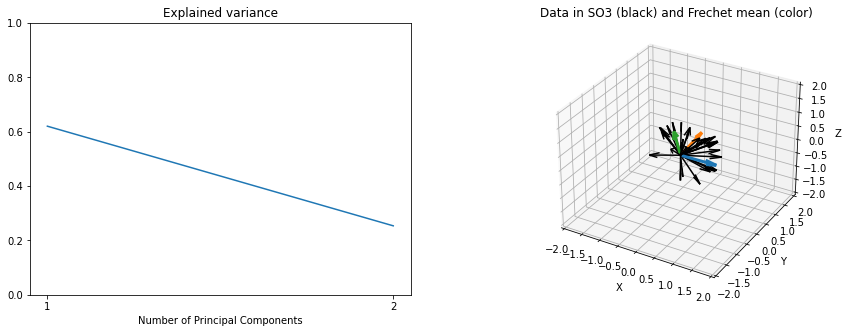

In [1]:
"""Perform tangent PCA at the mean on SO(3). This is done on a random set of points"""

import logging

import matplotlib.pyplot as plt
import numpy as np

import geomstats.visualization as visualization
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA

SO3_GROUP = SpecialOrthogonal(n=3, point_type="vector")
METRIC = SO3_GROUP.bi_invariant_metric

N_SAMPLES = 10
N_COMPONENTS = 2


def main():
    """Perform tangent PCA at the mean on SO(3)."""
    fig = plt.figure(figsize=(15, 5))

    data = SO3_GROUP.random_uniform(n_samples=N_SAMPLES)

    mean = FrechetMean(metric=METRIC)
    mean.fit(data)

    mean_estimate = mean.estimate_

    tpca = TangentPCA(metric=METRIC, n_components=N_COMPONENTS)
    tpca = tpca.fit(data, base_point=mean_estimate)
    tangent_projected_data = tpca.transform(data)
    logging.info(
        "Coordinates of the Log of the first 5 data points at the mean, "
        "projected on the principal components:"
    )
    logging.info("\n{}".format(tangent_projected_data[:5]))

    ax_var = fig.add_subplot(121)
    xticks = np.arange(1, N_COMPONENTS + 1, 1)
    ax_var.xaxis.set_ticks(xticks)
    ax_var.set_title("Explained variance")
    ax_var.set_xlabel("Number of Principal Components")
    ax_var.set_ylim((0, 1))
    ax_var.plot(xticks, tpca.explained_variance_ratio_)

    ax = fig.add_subplot(122, projection="3d")
    plt.setp(ax, xlabel="X", ylabel="Y", zlabel="Z")

    ax.set_title("Data in SO3 (black) and Frechet mean (color)")
    visualization.plot(data, ax, space="SO3_GROUP", color="black")
    visualization.plot(mean_estimate, ax, space="SO3_GROUP", linewidth=3)
    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))
    ax.set_zlim((-2, 2))
    plt.show()


if __name__ == "__main__":
    main()